# 3. Category Prediction using Video Title and Tags - Part 1

# Table of contents
1. [Import libraries](#import_libraries)
2. [Load and process data](#load_and_process_data)
    1. [Read in videos.csv](#read_in_videos.csv)
    2. [Label transformation](#label_transformation)
    3. [Create mappings from Video id -> Category id and Category id -> Category name](#mapping)
    4. [Drop categories with low counts](#drop)
    5. [Combine title and tags and clean them](#combine_clean)
    6. [Remove duplicates](#remove_duplicates)
    7. [Vectorize the comments](#vectorize)
    8. [Shuffle the data](#shuffle_data)
3. [Looking at baseline accuracies of models](#baseline)
4. [Tuning hyperparamters](#tuning) (Not all experiments are shown but best parameters are listed)
    1. [Tuning KNN](#tuning_knn)
    2. [Tuning Decision Tree](#tuning_dt)
    2. [Tuning Random Forest](#tuning_rf)
    3. [Tuning Logistic Regression](#tuning_logistic)
    4. [Tuning Support Vector Machine](#tuning_svm)
    5. [Tuning Naive Bayes](#tuning_nb)
    6. [Compare accuracies between models](#compare)
5. [Plotting confusion matrix for best model](#plotting)

### Import libraries <a name="import_libraries"></a>

In [2]:
import time
import pickle
import collections
import string
import warnings
import os
warnings.filterwarnings('ignore')
from pathlib import Path
cwd = Path('.')

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,30)
plt.rcParams.update({'font.size': 22})

import pandas as pd
import tensorflow as tf
import nltk

In [4]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
from random import seed
RANDOM = 42
seed(RANDOM)
np.random.seed(RANDOM)

### Load and process data <a name="load_and_process_data"></a>

#### Read in videos.csv <a name="read_in_videos.csv"></a>

In [6]:
videos_df = pd.read_csv(cwd/'output'/"videos.csv")

#### Category id is not in order. i.e. there are skips (0, 1, 2, 5 etc ) so we transform them <a name="label_transformation"></a>

In [7]:
le = preprocessing.LabelEncoder()
le.fit(videos_df['category_id'])
videos_df['category_id'] = le.transform(videos_df['category_id']) 

#### Save mapping Category id -> Category name <a name="mapping"></a>

In [8]:
category_id_to_word = {}
for _, row in videos_df.iterrows():
    if row['category_id'] not in category_id_to_word:
        category_id_to_word[row['category_id']] = row['category_name']

#### Notice that for category id 14 and 15, the count is extremely low, so we drop them <a name="drop"></a>

In [9]:
videos_df.groupby(['category_id']).agg(['count'])

,video_id,title,channel_title,tags,views,likes,dislikes,comment_total,thumbnail_link,date,likes_log,views_log,dislikes_log,comment_log,category_name,like_rate,dislike_rate,comment_rate
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
category_id,,,,,,,,,,,,,,,,,,
0,771,771,771,771,771,771,771,771,771,771,771,771,771,771,771,767,767,767
1,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183
2,2547,2547,2547,2547,2547,2547,2547,2547,2547,2547,2547,2547,2547,2547,2547,2532,2532,2533
3,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194
4,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114,1114
5,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94
6,334,334,334,334,334,334,334,334,334,334,334,334,334,334,334,334,334,334
7,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035,2035


In [10]:
videos_df = videos_df[videos_df['category_id'] != 15]
videos_df = videos_df[videos_df['category_id'] != 14]

#### Combine title and tags, and clean them <a name="combine_clean"></a>

In [11]:
def clean_and_join_title_and_tags(row, to_stem):
    # join title and tags
    text = row['title'] + ' ' + " ".join(row['tags'].split("|"))
    # tokenize
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [token for token in tokens if token.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # stemming words
    if to_stem:
        porter = PorterStemmer()
        words = [porter.stem(word) for word in words]
    return " ".join(words)

In [12]:
to_stem = False
videos_df['title_and_tags'] = videos_df.apply(lambda row: clean_and_join_title_and_tags(row, to_stem), axis=1)

In [13]:
videos_df['title_and_tags'][0]

'year vlogging logan paul changed youtube forever logan paul vlog logan paul logan paul olympics logan paul youtube vlog daily comedy hollywood parrot maverick bird maverick clothes diamond play button logan paul diamond play button subscribers logan paul year vlogging year vlog dwarf mamba play button logan paul history youtube history plaque youtube button diamond button logang logang life'

#### Remove duplicated title and tags <a name="remove_duplicates"></a>

In [14]:
videos_df = videos_df.drop_duplicates(subset='title_and_tags', keep='first')

#### Also, save the dataframe with combined and cleaned title and tags. Need for ensemble model notebook.

In [15]:
if not os.path.exists(cwd/'output'):
    os.mkdir(cwd/'output')

videos_df.to_csv(cwd/'output'/"title_tags_videos_df.csv", index=False)

#### Convert the cleaned titile and tags into feature vectors <a name='vectorize'></a>

In [16]:
vectorizer = TfidfVectorizer()
counts = vectorizer.fit_transform(videos_df['title_and_tags'].values)
counts.shape

(3388, 16376)

In [17]:
print(vectorizer.get_feature_names())

['aa', 'aac', 'aaron', 'ab', 'abandoned', 'abbey', 'abbott', 'abby', 'abc', 'abduction', 'abductions', 'abdul', 'abedin', 'aberdeen', 'abertura', 'abh', 'abiding', 'abilities', 'ability', 'abk', 'able', 'ableton', 'abloh', 'abn', 'abortion', 'abou', 'abraham', 'abrams', 'absurd', 'abu', 'abuja', 'abuse', 'aca', 'acadamy', 'academia', 'academic', 'academy', 'acapella', 'acappela', 'acappella', 'acar', 'acc', 'accdigitalnetwork', 'accdn', 'acceleration', 'accent', 'access', 'accessories', 'accident', 'accidental', 'accidentally', 'accidents', 'according', 'account', 'accounts', 'accusing', 'accutane', 'ace', 'acer', 'acetaldehyde', 'acetate', 'acetic', 'acetone', 'acetylene', 'acha', 'achievement', 'achievers', 'acid', 'aciman', 'ackles', 'acl', 'acm', 'acne', 'aco', 'acosta', 'acoustic', 'acoustics', 'acquittal', 'across', 'acs', 'act', 'acting', 'action', 'active', 'activision', 'activism', 'activist', 'actor', 'actors', 'actress', 'acts', 'actual', 'actually', 'actuation', 'acura', 'a

In [18]:
X = counts
y = videos_df['category_id'].to_numpy()

#### Shuffle the data before training <a name='shuffle_data'></a>

In [19]:
def unison_shuffled_copies(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]
X, y = unison_shuffled_copies(X, y)
X = np.nan_to_num(X)

### See baseline of some models to see if task is doable <a name='baseline'></a>

In [57]:
classifiers = {"LogisticRegression": LogisticRegression(),
               "MultinomialNB": MultinomialNB(),
               "RandomForestClassifier": RandomForestClassifier(),
               "SVC": SVC(probability=True),
               "KNeighborsClassifier": KNeighborsClassifier(),
               "DecisionTreeClassifier": DecisionTreeClassifier()}

In [58]:
accuracies = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM, stratify=y)
for classifier, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies[classifier] = accuracy_score(y_test, y_pred)

In [59]:
for classifier, accuracy in accuracies.items():
    print("{0:<50}{1:<25}\n".format(f"{classifier} has baseline accuracy of:", accuracy))
    #print(f"{classifier} has baseline accuracy of: {accuracy}")
print(f"\nThe average baseline accuracy is {sum(accuracies.values())/len(accuracies)}")

LogisticRegression has baseline accuracy of:      0.5914454277286135       

MultinomialNB has baseline accuracy of:           0.528023598820059        

RandomForestClassifier has baseline accuracy of:  0.6327433628318584       

SVC has baseline accuracy of:                     0.20206489675516223      

KNeighborsClassifier has baseline accuracy of:    0.6209439528023599       

DecisionTreeClassifier has baseline accuracy of:  0.5899705014749262       


The average baseline accuracy is 0.5275319567354966


In [60]:
1/len(collections.Counter(y))

0.07142857142857142

7% of randomly guessing

### Tuning <a name='tuning'></a>

#### You won't always get the same parameters as diff random seed / diff computer give different results :(

#### Tuning KNN <a name='tuning_knn'></a>
Best: 0.649941 using {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'distance'}

In [41]:
# Params
n_neighbors = range(1, 20)
algorithm = ['auto']
weights = ['distance']

param_grid = dict(n_neighbors=n_neighbors, algorithm=algorithm, weights=weights)

model = KNeighborsClassifier()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best: 0.649941 using {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'distance'}
Execution time: 1.6805050373077393 ms


[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    1.6s finished


#### Tuning Decision Tree <a name='tuning_dt'></a>
Baseline is the best already i think..

Best: 0.603601 using {'random_state': 42}

In [95]:
# Params
random_state = [RANDOM]

param_grid = dict(random_state=random_state)

model = DecisionTreeClassifier()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Best: 0.603601 using {'random_state': 42}
Execution time: 1.9198668003082275 ms


#### Tuning Random Forest <a name='tuning_rf'></a>
Best: 0.688312 using {'n_estimators': 87, 'random_state': 42}

In [45]:
# Params
n_estimators = range(81, 101)
random_state = [RANDOM]

param_grid = dict(n_estimators=n_estimators, random_state=random_state)

model = RandomForestClassifier()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Best: 0.688312 using {'n_estimators': 87, 'random_state': 42}
Execution time: 108.98533844947815 ms


#### Tuning Logistic Regression <a name='tuning_logistic'></a>
Best: 0.703365 using {'C': 50, 'penalty': 'l2', 'random_state': 42}

In [62]:
# Params
penalty = ['l2']
C = range(40, 61)
random_state = [RANDOM]

param_grid = dict(penalty=penalty, C=C, random_state=random_state)

model = LogisticRegression()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   10.1s finished


Best: 0.703365 using {'C': 50, 'penalty': 'l2', 'random_state': 42}
Execution time: 10.411162614822388 ms


#### Tuning Support Vector Machine <a name='tuning_svm'></a>
Best: 0.693329 using {'C': 11.1, 'gamma': 0.09, 'kernel': 'rbf', 'random_state': 42}

In [103]:
# Params
C = [10.7, 10.8, 10.9, 11.0, 11.1]
gamma = [0.07, 0.08, 0.09, 0.10, 0.11]
kernel = ['rbf']
random_state = [RANDOM]
param_grid = dict(C=C, gamma=gamma, kernel=kernel, random_state=random_state)

model = SVC()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.9min finished


Best: 0.693329 using {'C': 11.1, 'gamma': 0.09, 'kernel': 'rbf', 'random_state': 42}
Execution time: 116.46165132522583 ms


#### Tuning Naive Bayes <a name='tuning_nb'></a>
Best: 0.709563 using {'alpha': 0.12, 'fit_prior': False}

In [24]:
# Params
alpha = np.linspace(0.0, 0.2, num=21)
fit_prior = [True, False]
param_grid = dict(alpha=alpha, fit_prior=fit_prior)

model = MultinomialNB()
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=3)
start_time = time.time()
result = CV.fit(X, y)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


Best: 0.708087 using {'alpha': 0.19, 'fit_prior': False}
Execution time: 2.180708885192871 ms


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.1s finished


#### Compare accuracies between models <a name="compare"></a>

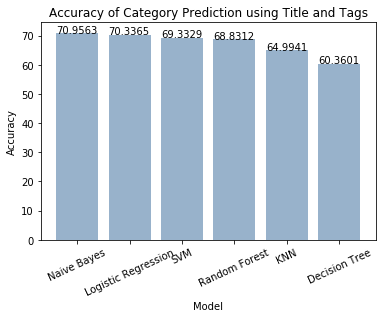

In [20]:
objects = ('Naive Bayes','Logistic Regression','SVM','Random Forest','KNN', 'Decision Tree', )
y_pos = np.arange(len(objects))
performance = [70.9563, 70.3365,69.3329,68.8312,64.9941,60.3601]

bars =plt.bar(y_pos, performance, align='center', alpha=0.5,color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(y_pos, objects, rotation=25)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracy of Category Prediction using Title and Tags')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.show()

### Plot confusion matrix for best model <a name='plotting'></a>

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          type_of_plot,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if type_of_plot == 'precision':
        cm = cm.astype('float') / cm.sum(axis=0)
        print("Precision confusion matrix")
    if type_of_plot == 'recall':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif type_of_plot == "no_normalization":
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if type_of_plot != "no_normalization" else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

#### Get the predictions for plotting

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM, stratify=y)
classifier = MultinomialNB(alpha=0.12, fit_prior=False)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

#### Do the actual plotting. Note if the figures produced are small, rerun the rcParams block at the start of notebook

Confusion matrix, without normalization
Precision confusion matrix


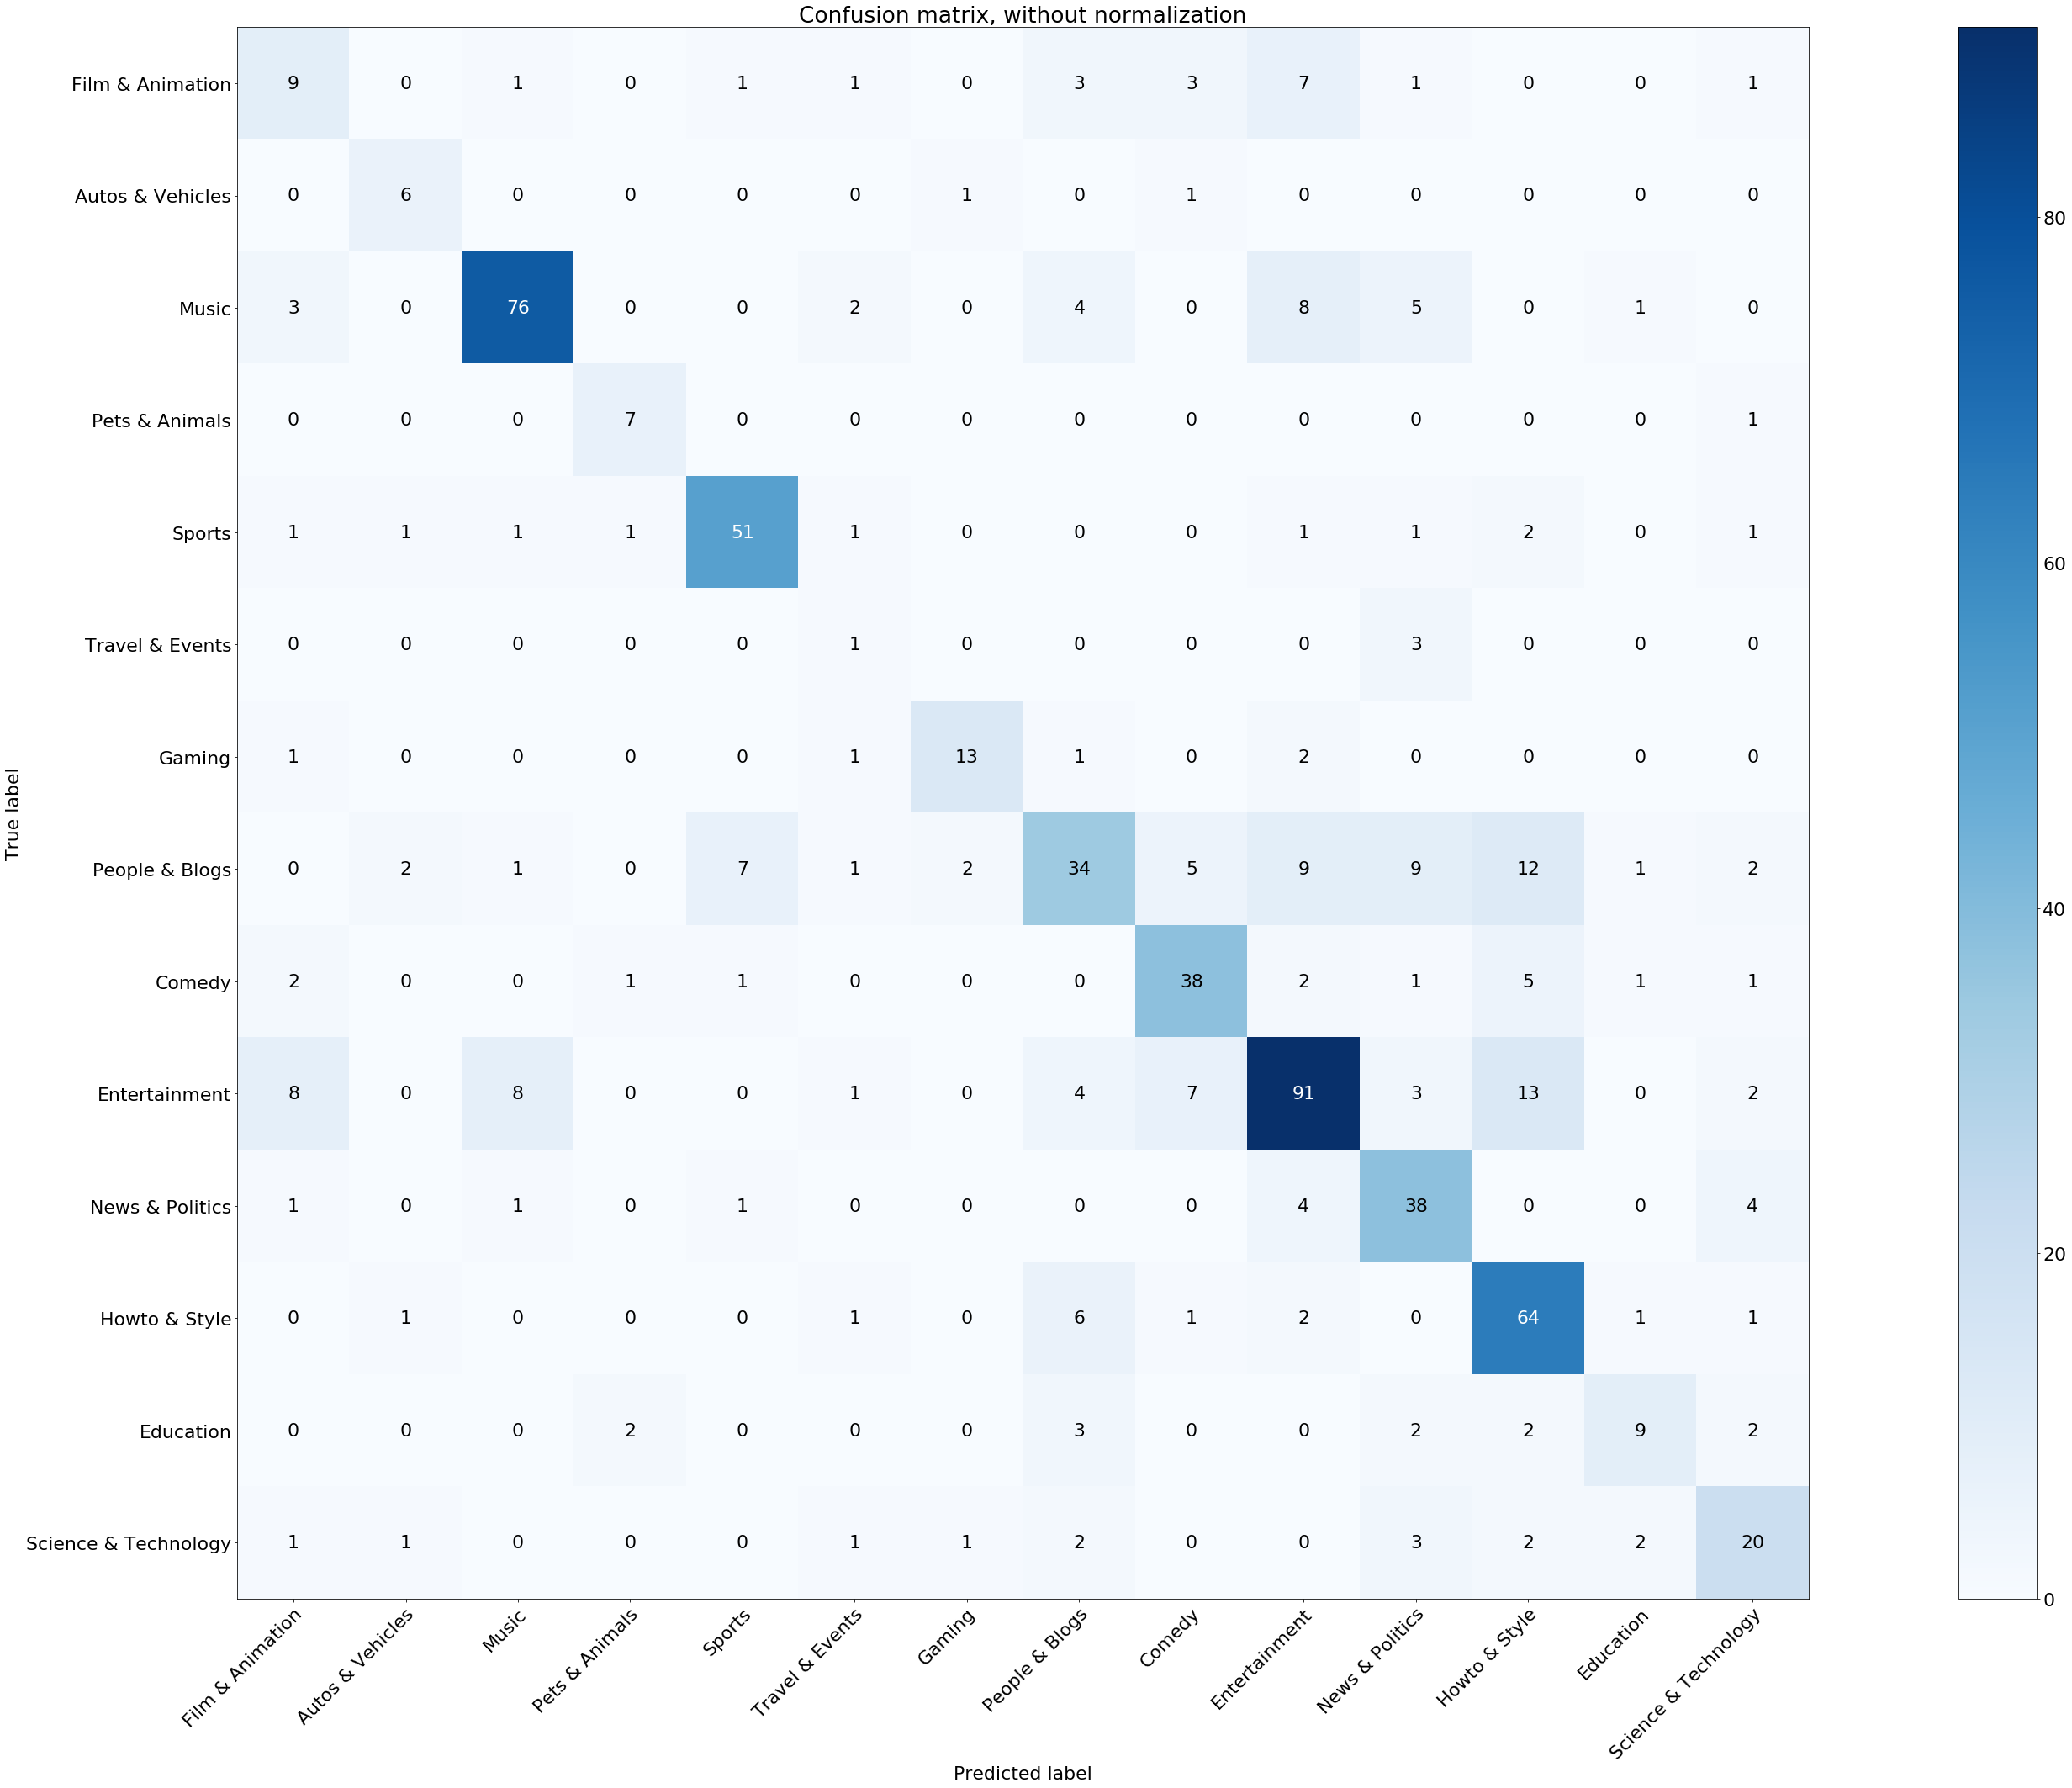

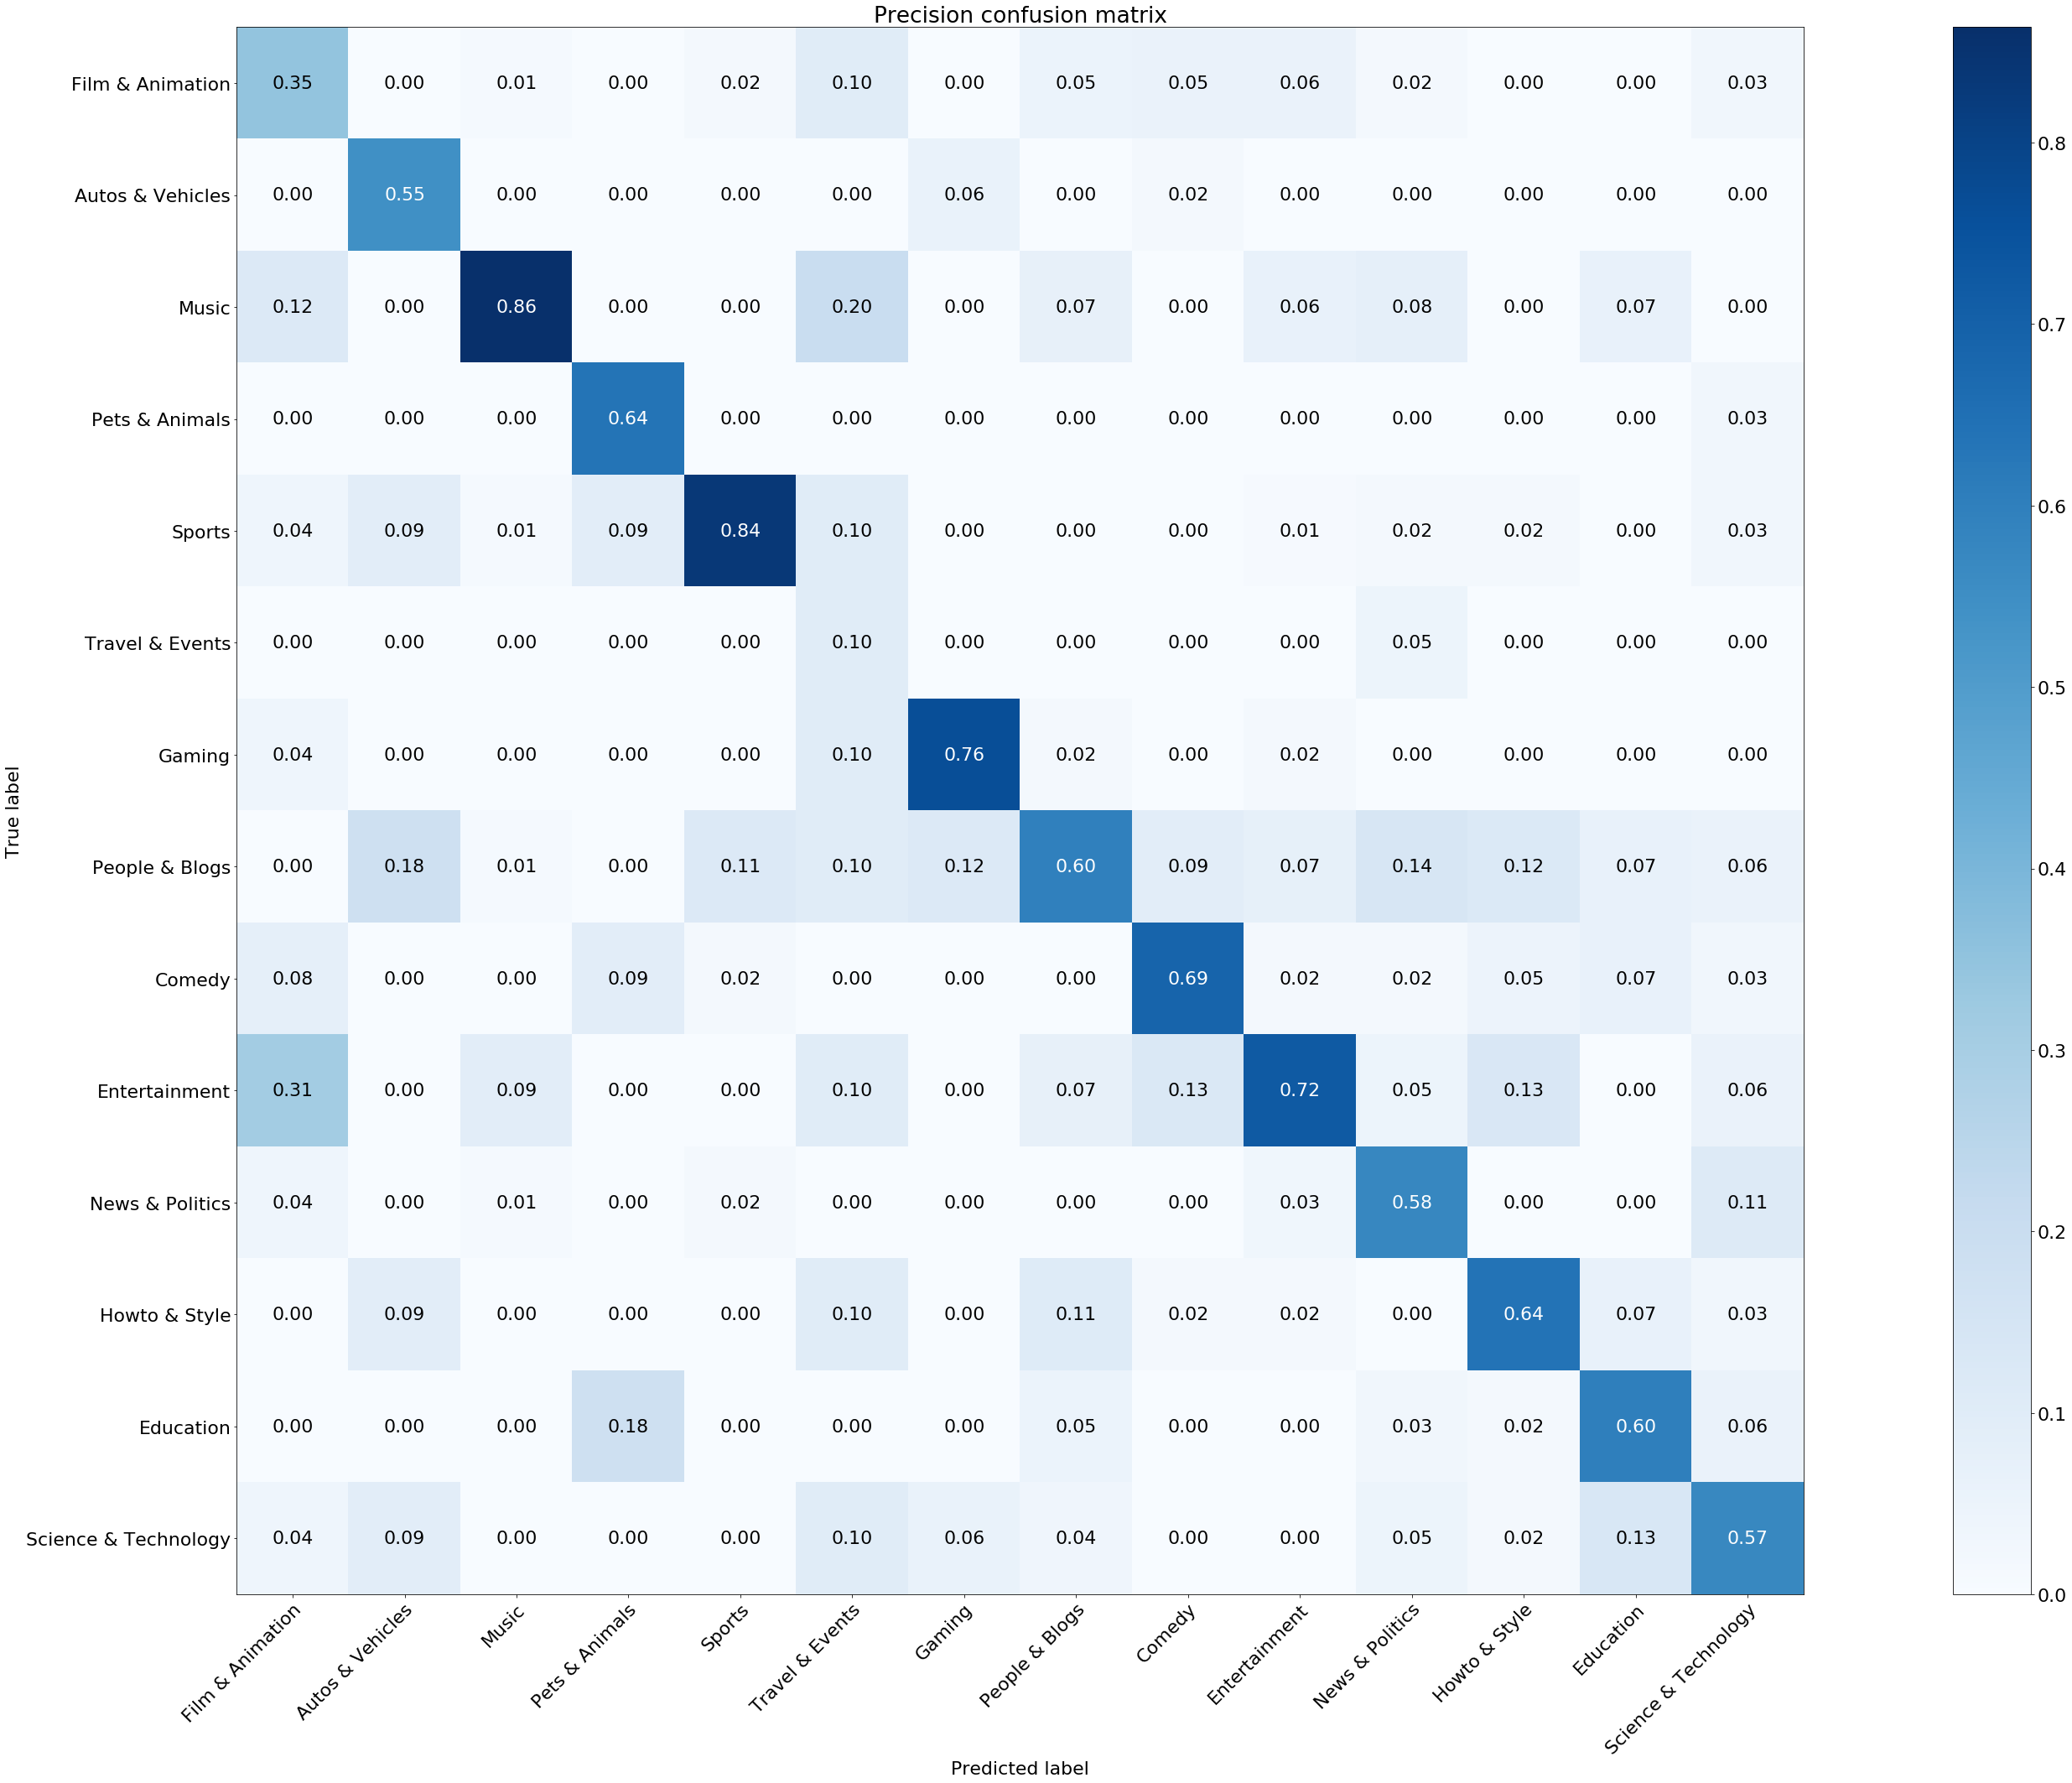

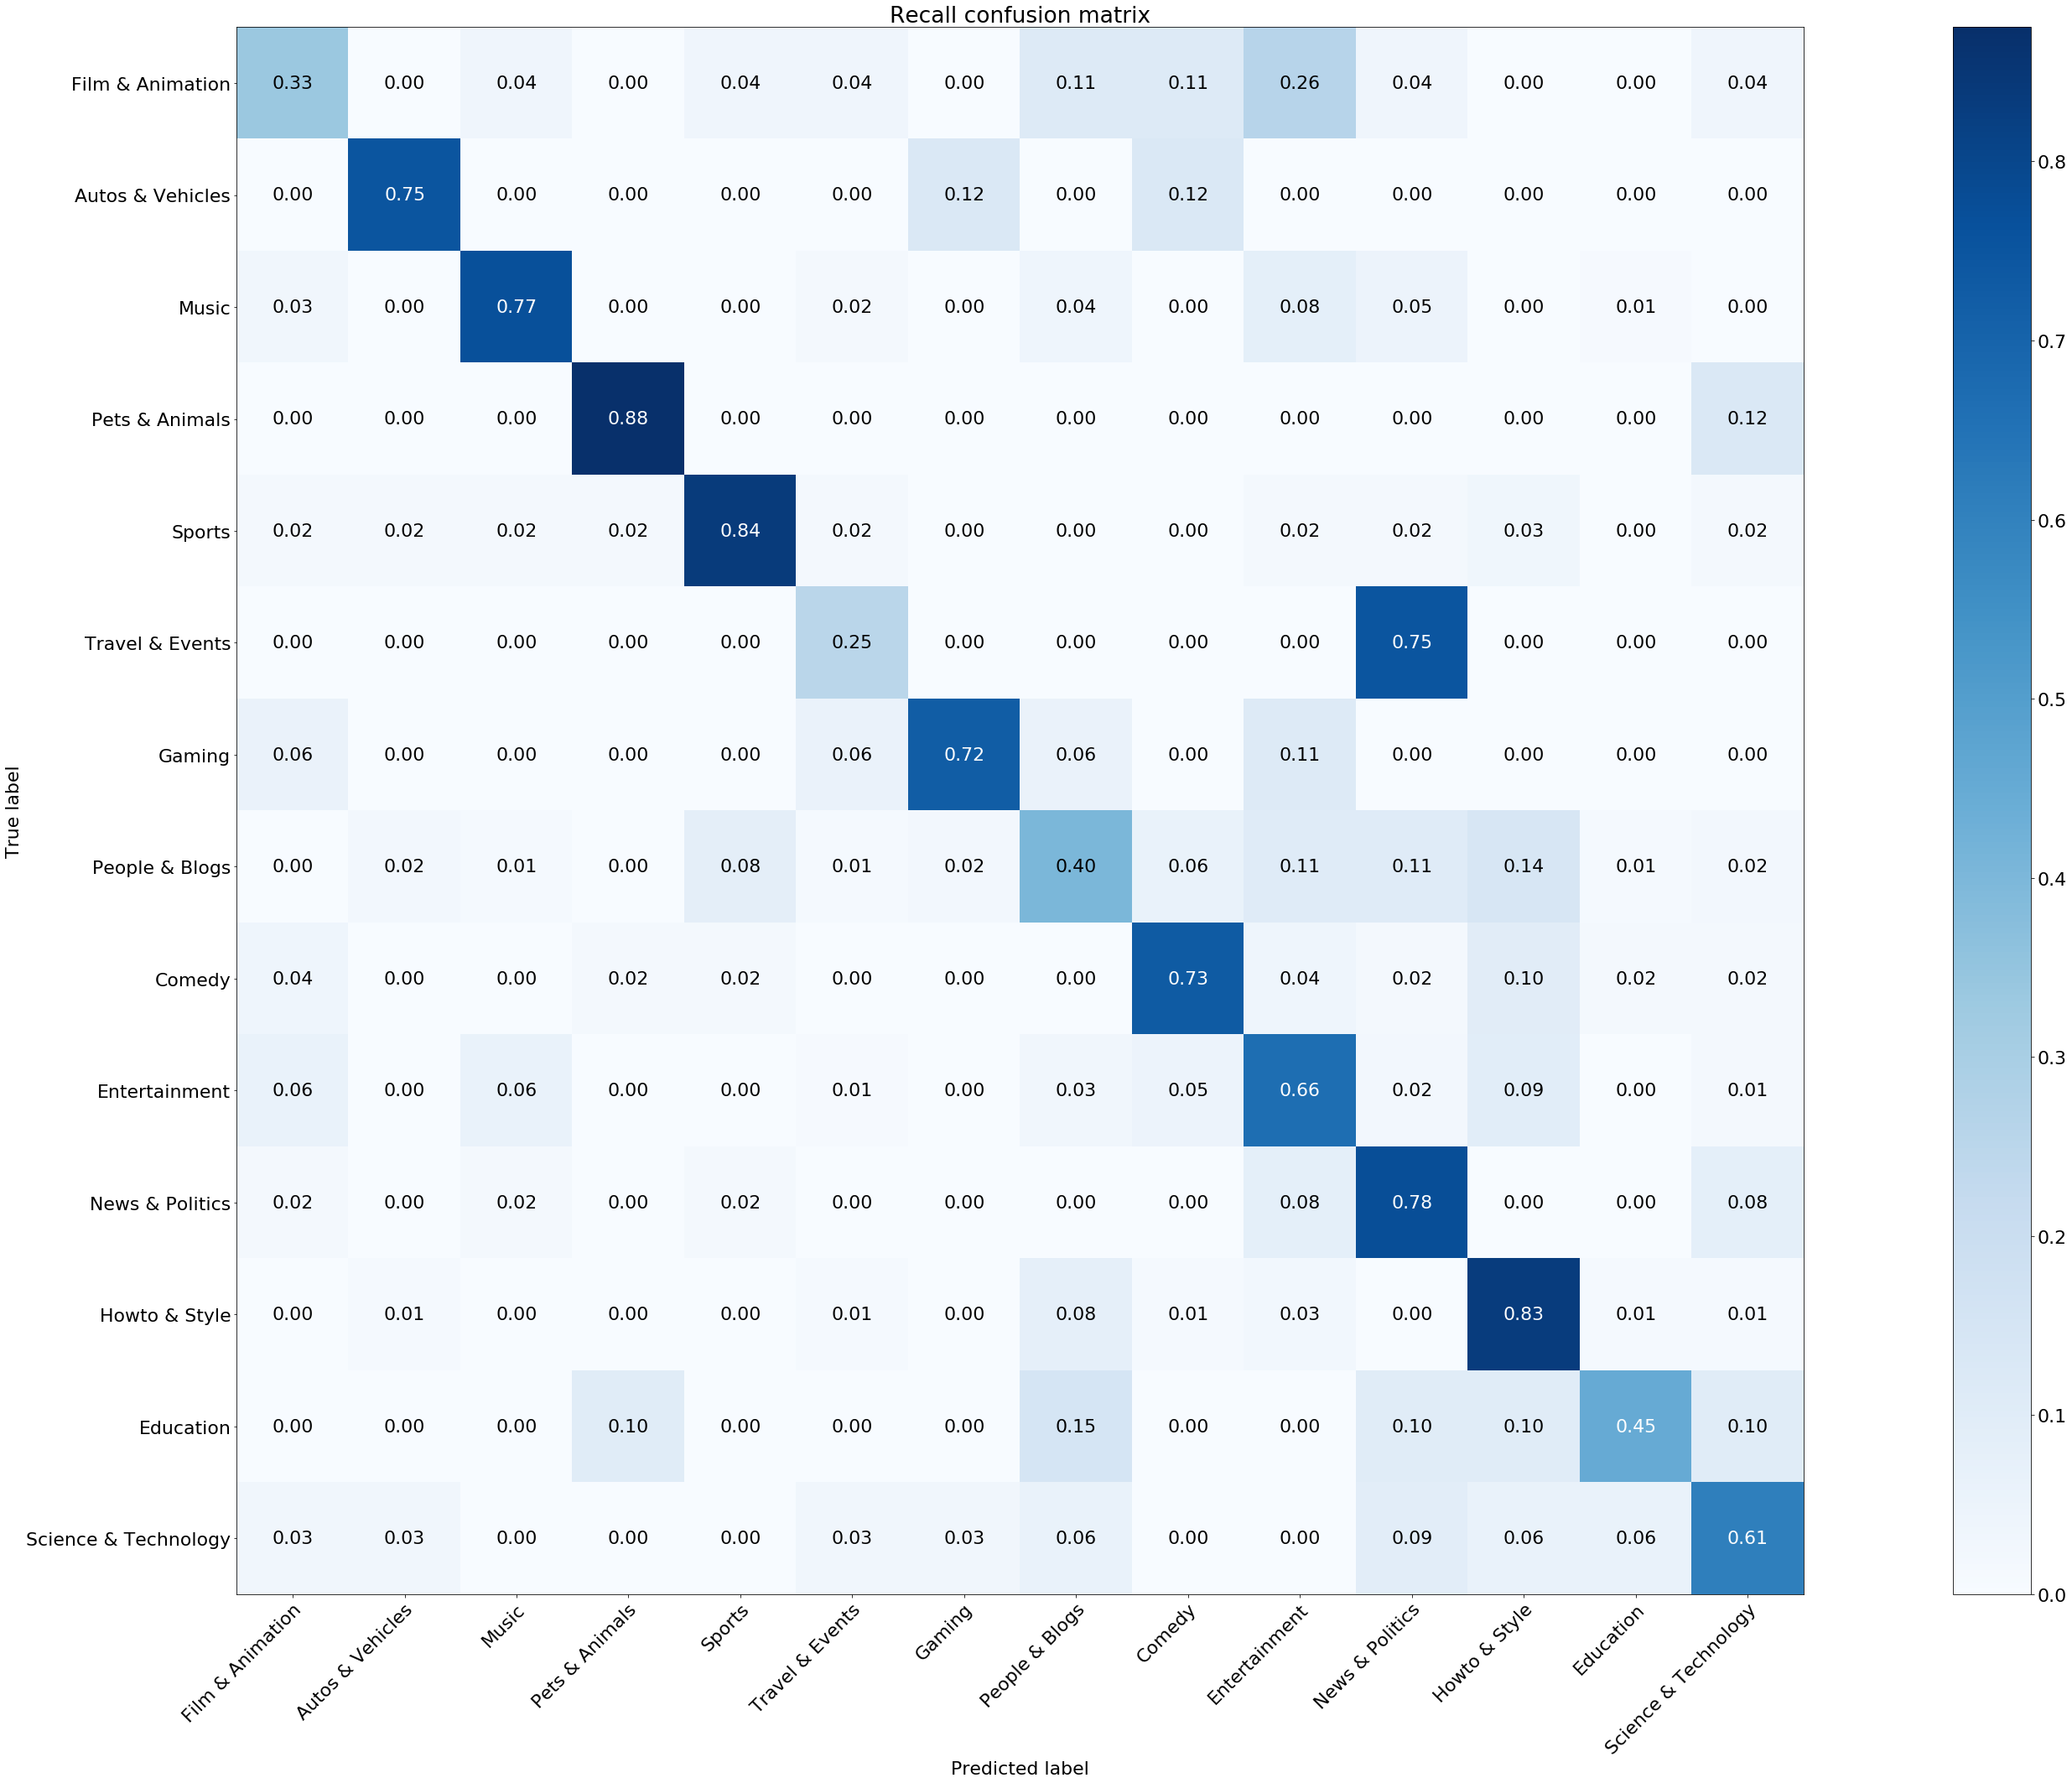

In [29]:
np.set_printoptions(precision=2)
class_names = np.array([i[1] for i in sorted(list(category_id_to_word.items()), key=lambda x: x[0])])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, type_of_plot="no_normalization",
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, type_of_plot="precision",
                      title='Precision confusion matrix')

plot_confusion_matrix(y_test, y_pred, classes=class_names, type_of_plot="recall",
                      title='Recall confusion matrix')


plt.show()